<a href="https://colab.research.google.com/github/ZUHAIR-5421342/Data-Analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Overview

### Data Source:
https://od.data.gov.sa/Data/ar/dataset/patient-experience-for-phcs-jan-2021

### Overview:

The selected dataset is a dataset of patients experience gathered by survey consist of 50 questions and a final column for the overview of patient experience which will be our predictor column for the rest of the project.

### Pros of this data:
* Responses are encoded into numerical values instead of text.
* Dataset have 5000 entries giving us the room for trimming the dataset while cleaning and also good for model training process.

### Cons of this data:
* Have missing values in responses due to which we have to drop many rows.
* Since the dataset have missing categorical values making it hard to fill those null out.

# Loading dataset

In [ ]:
# Importing libraries

# Module for data cleaning and transformation
import pandas as pd

# Module for preprocessing
from sklearn.model_selection import train_test_split

# Modules for classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression

# Modules for checking the outcome of training and testing
from sklearn.metrics import accuracy_score, classification_report

# Module for ignoring the warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
# Loading the dataset

df = pd.read_excel("patient-experience-jan21.xlsx", sheet_name="Responses")

In [ ]:
# Taking an overview of the dataset

df

,No.,amenddate,unit,age,gender,nationality,q1,q2,q3,q4,...,q42,q43,q44,q45,q46,q47,q48,q49,q50,adaa
0,1,2021-01-01 00:00:04,phc312,36,MALE,SAU,1.0,1.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN
1,2,2021-01-01 00:00:19,phc433,62,MALE,SAU,NaN,1.0,5.0,5.0,...,1.0,5.0,5.0,5.0,2.0,NaN,NaN,NaN,NaN,5.0
2,3,2021-01-01 00:00:23,phc777,63,MALE,SAU,1.0,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2021-01-01 00:00:26,phc1479,38,MALE,SAU,1.0,2.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN
4,5,2021-01-01 00:00:30,phc962,52,FEMALE,SAU,1.0,2.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4995,2021-01-05 12:04:52,phc367,43,FEMALE,SAU,2.0,2.0,5.0,5.0,...,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0
4995,4996,2021-01-05 12:05:43,phc077,0,FEMALE,SAU,1.0,2.0,5.0,4.0,...,1.0,5.0,5.0,3.0,2.0,NaN,NaN,NaN,NaN,3.0
4996,4997,2021-01-05 12:06:11,phc635,37,FEMALE,SAU,1.0,2.0,5.0,5.0,...,2.0,NaN,NaN,NaN,2.0,NaN,NaN,5.0,5.0,5.0
4997,4998,2021-01-05 12:06:33,phc043,35,FEMALE,SAU,1.0,2.0,5.0,5.0,...,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,5.0


# Cleaning Data

In [ ]:
# Creating encoders for encoding those columns which are not encoded in the dataframe

gender_encoder = dict(
    zip(
        df['gender'].unique().tolist(),
        [i for i in range(3)]
    )
)

nationality_encoder = dict(
    zip(
        df['nationality'].unique().tolist(),
        [i for i in range(len(df['nationality'].unique().tolist()))]
    )
)

In [ ]:
# Encoding the dataframe categorical columns

df['gender'].replace(gender_encoder, inplace=True)
df['nationality'].replace(nationality_encoder, inplace=True)

In [ ]:
# droping out rows which have null in the predictor column 'adaa'

df = df[df['adaa'].notna()]

In [ ]:
# checking out null values in columns of the dataset

check_null = pd.DataFrame(round(df.isna().sum()/len(df)*100, 2), columns=['missing_percentage'])
check_null['drop_it'] = check_null['missing_percentage'].apply(lambda x: True if x > 50 else False)
check_null[check_null['missing_percentage']>0].style.background_gradient(cmap='coolwarm')

,missing_percentage,drop_it
q1,3.290000,False
q2,0.920000,False
q3,2.420000,False
q4,2.590000,False
q5,1.260000,False
q6,5.570000,False
q7,1.820000,False
q8,1.430000,False
q9,100.000000,True
q10,2.030000,False


In [ ]:
# Dropping out the columns which have more than 50 percent of missing values

cols_to_drop = check_null[check_null['drop_it'] == True].index.tolist()

df.drop(columns=cols_to_drop, axis=1, inplace=True)

In [ ]:
# Filling out the null values from rest of the columns with mode since these are categorical columns

for col in df.columns.to_list()[6:-1]:
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# Again checking missing values after filling null

check_null = pd.DataFrame(round(df.isna().sum()/len(df)*100, 2), columns=['missing_percentage'])
check_null[check_null['missing_percentage']>0].style.background_gradient(cmap='coolwarm')

,missing_percentage


# Feature Selection

Checking the correlation of data features with the predictor column in order to select only those parameters which contribute in classification.

In [ ]:
cor = df.iloc[:, 3:].corr()[['adaa']]
cor.rename(columns={'adaa': 'correlation'}, inplace=True)
cor['feature_selected'] = cor['correlation'].apply(lambda x: 'Yes' if x > 0.5 else 'No')
cor.style.background_gradient(cmap='coolwarm')

,correlation,feature_selected
age,0.100944,No
gender,-0.058078,No
nationality,0.028292,No
q1,-0.024547,No
q2,0.003337,No
q3,0.657876,Yes
q4,0.678934,Yes
q5,0.697846,Yes
q6,0.727217,Yes
q7,0.733038,Yes


<Axes: title={'center': 'Correlation of questions in the survey with outcome column'}>

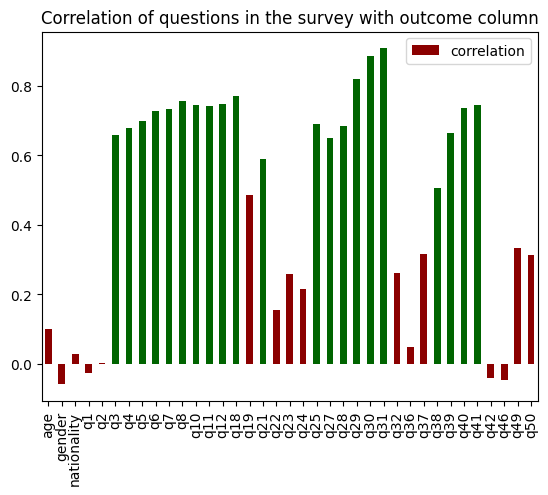

In [ ]:
cor.iloc[:-1, :].plot(
    kind='bar',
    y='correlation',
    color=["darkred" if i == 'No' else 'darkgreen' for i in cor.iloc[:-1, 1].to_list()],
    title='Correlation of questions in the survey with outcome column'
)

In [ ]:
cor.iloc[:-1, :].sort_values(by='correlation', ascending=False).iloc[0]

correlation         0.906956
feature_selected         Yes
Name: q31, dtype: object

The most relevent question for making the decision is "q31" as this question have the highest correlation with the predictor column.

In [ ]:
df = df[cor[cor['feature_selected'] == 'Yes'].index.tolist()]

# Final dataframe

In [ ]:
df

,q3,q4,q5,q6,q7,q8,q10,q11,q12,q18,...,q27,q28,q29,q30,q31,q38,q39,q40,q41,adaa
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
8,4.0,4.0,4.0,4.0,3.0,4.0,5.0,5.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0
9,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
11,1.0,1.0,1.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,...,1.0,4.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0
13,5.0,3.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,3.0,...,4.0,4.0,4.0,4.0,5.0,5.0,3.0,3.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,5.0,5.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0
4995,5.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4.0,5.0,4.0,2.0,5.0,4.0,5.0,4.0,5.0,3.0
4996,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4997,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0


# Basic statistics of data features

In [ ]:
df.describe().apply(lambda x: round(x, 2))

,q3,q4,q5,q6,q7,q8,q10,q11,q12,q18,...,q27,q28,q29,q30,q31,q38,q39,q40,q41,adaa
count,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,...,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00,4131.00
mean,4.40,4.35,4.05,4.09,4.35,4.34,4.37,4.41,4.34,4.25,...,4.48,4.34,4.30,4.18,4.24,4.31,3.97,4.36,4.29,4.19
std,1.09,1.13,1.34,1.33,1.17,1.18,1.17,1.14,1.19,1.28,...,0.96,1.06,1.16,1.28,1.23,1.15,1.31,1.15,1.23,1.26
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,4.00,4.00,3.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,...,4.00,4.00,4.00,4.00,4.00,4.00,3.00,4.00,4.00,4.00
50%,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
75%,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00


# Visualizing the outcome categories

<Axes: title={'center': 'Categorical distribution in outcome column'}, xlabel='adaa'>

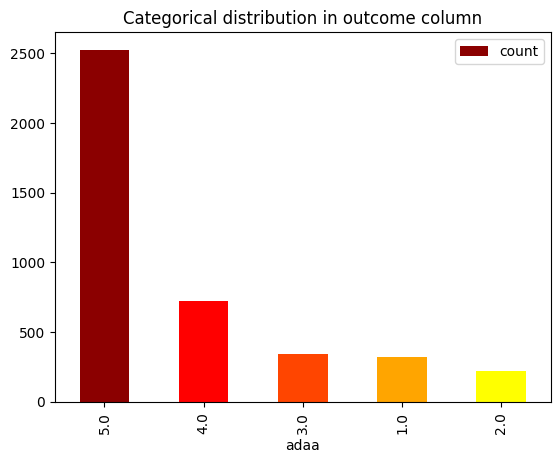

In [ ]:
pd.DataFrame(df['adaa'].value_counts()).reset_index().rename(
    columns={'index': 'adaa', 'adaa': 'count'}
).plot(
    kind='bar',
    x='adaa',
    y='count',
    color=['darkred', 'red', 'orangered', 'orange', 'yellow'],
    title='Categorical distribution in outcome column'
)

<Axes: title={'center': 'Categorical distribution in outcome column'}>

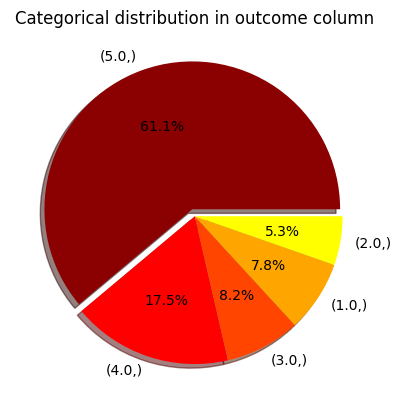

In [ ]:
df[['adaa']].value_counts().plot(
    kind='pie',
    y='adaa',
    autopct='%1.1f%%',
    shadow=True,
    colors=['darkred', 'red', 'orangered', 'orange', 'yellow'],
    explode=[0.05, 0, 0, 0, 0],
    title='Categorical distribution in outcome column'
)

The dataset tends towards the outcome 5 that's why it is an imbalanced data set and the reviewers are biased towards their openion.

# Statistical Modeling

Since the predictor column have multi-class outcomes so we could consider:
* k-Nearest Neighbors (KNN)
* Decision Tree
* Naive Bayes
* Logistic Regression

Also the dataset have imbalanced classification problem that's why models will perform not much different from one another.

In [ ]:
# creating numpy arrays of input parameters and output parameter

X = df[[col for col in df.columns.to_list()[:-1]]].to_numpy()
y = df['adaa'].to_numpy()

# splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Decision Tree Classifier

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
tree_score = round(accuracy_score(y_test, y_pred_tree), 2)

print(f"Accuracy score of decision tree: {tree_score}")

Accuracy score of decision tree: 0.78


In [ ]:
# classification report for decision tree classifier

print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

         1.0       0.79      0.72      0.75       102
         2.0       0.41      0.44      0.43        75
         3.0       0.40      0.44      0.42       116
         4.0       0.57      0.57      0.57       227
         5.0       0.93      0.92      0.93       844

    accuracy                           0.78      1364
   macro avg       0.62      0.62      0.62      1364
weighted avg       0.79      0.78      0.78      1364



## K-Nearest Neighbors (KNN) Classifier

In [ ]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
knn_score = round(accuracy_score(y_test, y_pred_knn), 2)

print(f"Accuracy score of KNN classifier: {knn_score}")

Accuracy score of KNN classifier: 0.78


In [ ]:
# classification report for KNN classifier

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         1.0       0.66      0.64      0.65       102
         2.0       0.25      0.19      0.21        75
         3.0       0.41      0.31      0.35       116
         4.0       0.58      0.64      0.61       227
         5.0       0.92      0.95      0.94       844

    accuracy                           0.78      1364
   macro avg       0.56      0.54      0.55      1364
weighted avg       0.76      0.78      0.77      1364



## Naive Bayes Classifier

In [ ]:
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
nb_score = round(accuracy_score(y_test, y_pred_nb), 2)

print(f"Accuracy score of Naive Bayes classifier: {nb_score}")

Accuracy score of Naive Bayes classifier: 0.81


In [ ]:
# classification report for Naive Bayes classifier

print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

         1.0       0.76      0.70      0.73       102
         2.0       0.47      0.48      0.47        75
         3.0       0.49      0.57      0.52       116
         4.0       0.65      0.63      0.64       227
         5.0       0.94      0.93      0.93       844

    accuracy                           0.81      1364
   macro avg       0.66      0.66      0.66      1364
weighted avg       0.81      0.81      0.81      1364



## Logistic Regression Classifier

In [ ]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)
lr_score = round(accuracy_score(y_test, y_pred_lr), 2)

print(f"Accuracy score of Logistic Regression classifier: {lr_score}")

Accuracy score of Logistic Regression classifier: 0.79


In [ ]:
# classification report for Logistic Regression classifier

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         1.0       0.65      0.86      0.74       102
         2.0       0.42      0.13      0.20        75
         3.0       0.43      0.11      0.18       116
         4.0       0.54      0.60      0.57       227
         5.0       0.90      0.98      0.94       844

    accuracy                           0.79      1364
   macro avg       0.59      0.54      0.53      1364
weighted avg       0.76      0.79      0.76      1364



## Comparing accuracies of different models

<Axes: title={'center': 'Accuracies of different statistical models'}, xlabel='Model'>

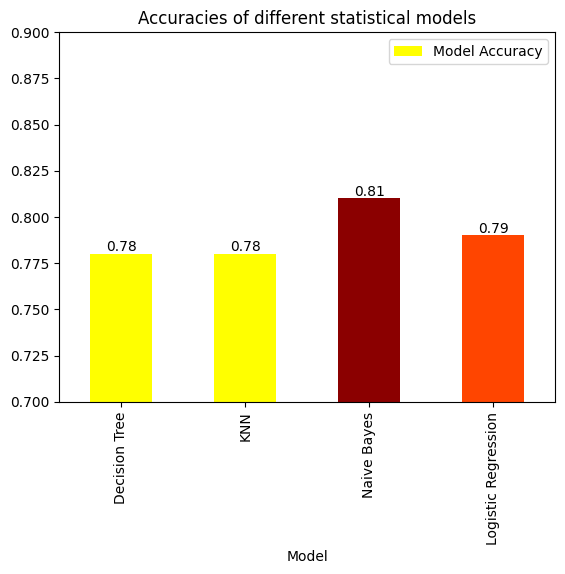

In [ ]:
ac_df = pd.DataFrame(
    {
        'Model': ['Decision Tree', 'KNN', 'Naive Bayes', 'Logistic Regression'],
        'Model Accuracy':[tree_score, knn_score, nb_score, lr_score]
    }
)

ax = ac_df.plot(
    kind='bar',
    y='Model Accuracy',
    ylim=(0.7, 0.9),
    x='Model',
    title='Accuracies of different statistical models',
    color=['yellow', 'yellow', 'darkred', 'orangered']
)

ax.bar_label(ax.containers[0])

ax

# Summary

* From these classification models we can predict the overall user experince from just 21 questions out of 50.
* The most relevent question among 50 questions is "q31".
* Naive Bayes out performs all models in multiclass classification for this imbalanced dataset with 81% accuracy.
* The support in classification report indicates how imbalanced the classes are in the predicted column.

## For future:

* Optimize the questionnaire in such a way that the outcome column will be balanced.
* Select the reviewers more randomly so that the reviews are not biased towards a specific class.
* Since age, gender and nationality have no correlation with the outcome so that we should not consider the reviewer's age, gender or nationality while taking the experience review.
* The research in this field would lead us to make a system where we can increase the user experience while keeping the person in an automated envoirnment.